In [35]:
# 📦 Chargement des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from datetime import datetime
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from matplotlib.ticker import MaxNLocator

# 🎨 Paramètres d'affichage
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_style("whitegrid")
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (10, 6)


🧭 Étape 1 : Exploration et Premier Diagnostic

Dimensions initiales : (1178819, 24)
Aperçu initial :
  comment_id  score                                          self_text  \
0    mzuvzkd      1  Six Italian cities - Bologna, Bolzano, Brescia...   
1    mzuvu1q      1  Yeah this is something I've thought about and ...   
2    mzuvq1d      1  Six Italian cities - Bologna, Bolzano, Brescia...   

      subreddit         created_time  post_id    author_name  \
0   environment  2025-06-26 10:17:33  1lkwhsi       Wagamaga   
1  changemyview  2025-06-26 10:16:13  1lizd5f  MrPokerfaceCz   
2        europe  2025-06-26 10:15:14  1lkwg1t       Wagamaga   

   controversiality  ups  downs  ... user_link_karma user_comment_karma  \
0                 0    1      0  ...     12751670.00          468589.00   
1                 0    1      0  ...          877.00           15618.00   
2                 0    1      0  ...     12751670.00          468589.00   

   user_total_karma  post_score  \
0       13220259.00           1   
1          16495.00  

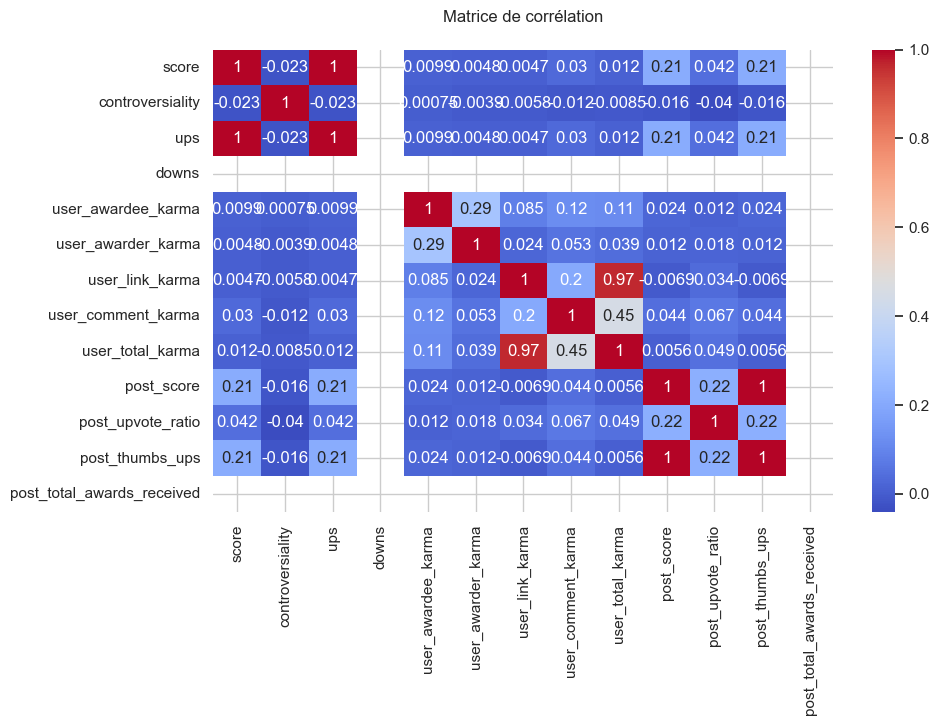

In [36]:

# 5.1 — Chargement du fichier avec gestion des types
df = pd.read_csv(
    'reddit_opinion_climate_change.csv',
    low_memory=False,
    dtype={'user_is_verified': str}  # colonne mixte, forçage en str
)

# 5.2 — Aperçu des données
print("Dimensions initiales :", df.shape)
print("Aperçu initial :")
print(df.head(3))
print(df.info())

# 5.3 — Suppression des colonnes trop manquantes (> 60%)
missing_threshold = 0.6
missing_percent = df.isnull().mean()
cols_to_drop = missing_percent[missing_percent > missing_threshold].index.tolist()
print("Colonnes supprimées (trop de NaNs) :", cols_to_drop)
df.drop(columns=cols_to_drop, inplace=True)

# 5.4 — Traitement des valeurs manquantes restantes

# Colonnes essentielles : suppression des lignes si NaN
essential_cols = ['self_text', 'user_is_verified', 'user_account_created_time']
df.dropna(subset=essential_cols, inplace=True)

# Autres colonnes numériques : imputation par la médiane (optionnel)
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Colonnes textuelles restantes : imputation par valeur neutre
text_cols = df.select_dtypes(include='object').columns
df[text_cols] = df[text_cols].fillna("inconnu")

# 5.5 — Conversion de colonnes en datetime
date_cols = ['created_time', 'post_created_time', 'user_account_created_time']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# 5.6 — Suppression des doublons
before = df.shape[0]
df.drop_duplicates(inplace=True)
after = df.shape[0]
print(f"Doublons supprimés : {before - after}")

# 5.7 — Vérifications finales
print("\nDimensions finales :", df.shape)
print("Valeurs manquantes restantes par colonne :")
print(df.isnull().sum()[df.isnull().sum() > 0])
print("Types finaux :")
print(df.dtypes)

# 🔗 Matrice de corrélation
num_cols = df.select_dtypes(include=np.number).columns
plt.figure()
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()


🧹 Étape 2 : Nettoyage et Préparation des Données

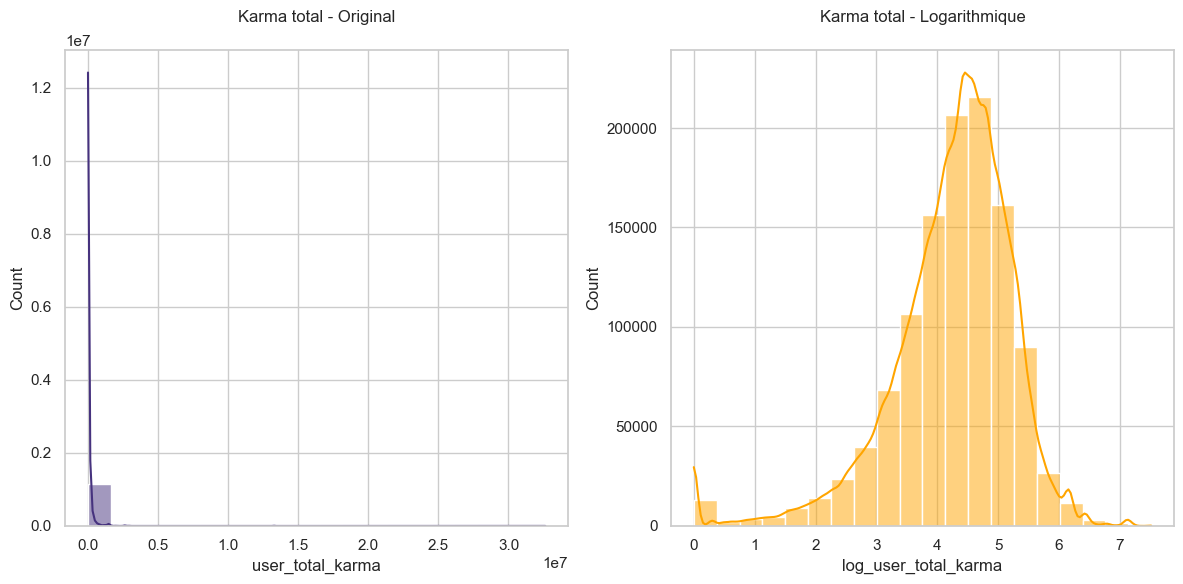

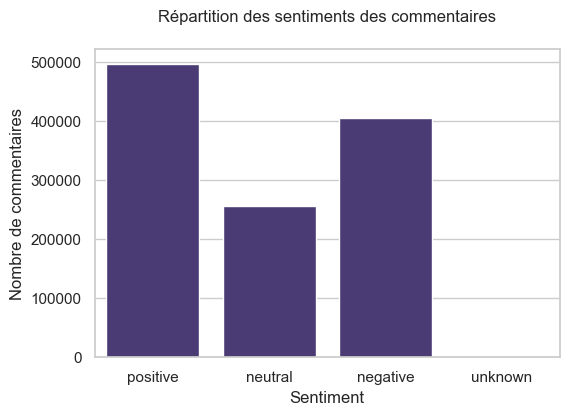

In [37]:
# Télécharger le lexique VADER (silencieux si déjà présent)
nltk.download('vader_lexicon', quiet=True)

# --- Conversion des dates ---
df['created_time'] = pd.to_datetime(df['created_time'], errors='coerce')
df['user_account_created_time'] = pd.to_datetime(df['user_account_created_time'], errors='coerce')
df['post_created_time'] = pd.to_datetime(df['post_created_time'], errors='coerce')

# --- Ancienneté du compte en jours ---
df['account_age_days'] = (df['created_time'] - df['user_account_created_time']).dt.days

# --- Nettoyage et transformation logarithmique des karma ---
karma_cols = ['user_link_karma', 'user_comment_karma', 'user_total_karma']
for col in karma_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    df[col] = df[col].apply(lambda x: max(x, 0))  # Pas de valeurs négatives
    df[f'log_{col}'] = np.log10(df[col] + 1)

# --- Longueur des textes ---
df['self_text_length'] = df['self_text'].fillna('').astype(str).str.len()

# --- Normalisation du score ---
if df['post_score'].max() != df['post_score'].min():
    df['normalized_post_score'] = (
        (df['post_score'] - df['post_score'].min()) /
        (df['post_score'].max() - df['post_score'].min())
    )
else:
    df['normalized_post_score'] = 0.0

# --- Analyse de sentiment avec VADER ---
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return np.nan
    return sia.polarity_scores(text)['compound']

df['sentiment_score'] = df['self_text'].apply(get_sentiment)

def categorize_sentiment(score):
    if pd.isna(score):
        return 'unknown'
    elif score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['sentiment_score'].apply(categorize_sentiment)

# --- Visualisations ---

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['user_total_karma'], bins=20, kde=True)
plt.title("Karma total - Original")

plt.subplot(1, 2, 2)
sns.histplot(df['log_user_total_karma'], bins=20, kde=True, color='orange')
plt.title("Karma total - Logarithmique")

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='sentiment', order=['positive', 'neutral', 'negative', 'unknown'])
plt.title("Répartition des sentiments des commentaires")
plt.xlabel("Sentiment")
plt.ylabel("Nombre de commentaires")
plt.show()


🧪 Étape 3 : Investigation d’un Comportement Complexe
🎯 Objectif : Identifier des sous-groupes ou comportements bimodaux

In [39]:
# 👤 Détection des super utilisateurs
df['user_type'] = np.where(df['user_total_karma'] > 100000, 'super_user', 'regular_user')
print(df['user_type'].value_counts())

# 📊 Comparaison des groupes
print(df.groupby('user_type').agg({
    'account_age_days': 'mean',
    'log_user_total_karma': 'mean',
    'subreddit': lambda x: x.mode()[0]
}))


user_type
regular_user    918493
super_user      238225
Name: count, dtype: int64
              account_age_days  log_user_total_karma      subreddit
user_type                                                          
regular_user           1709.91                  3.95  climatechange
super_user             2944.44                  5.39        climate


📈 Visualisation bimodale du karma

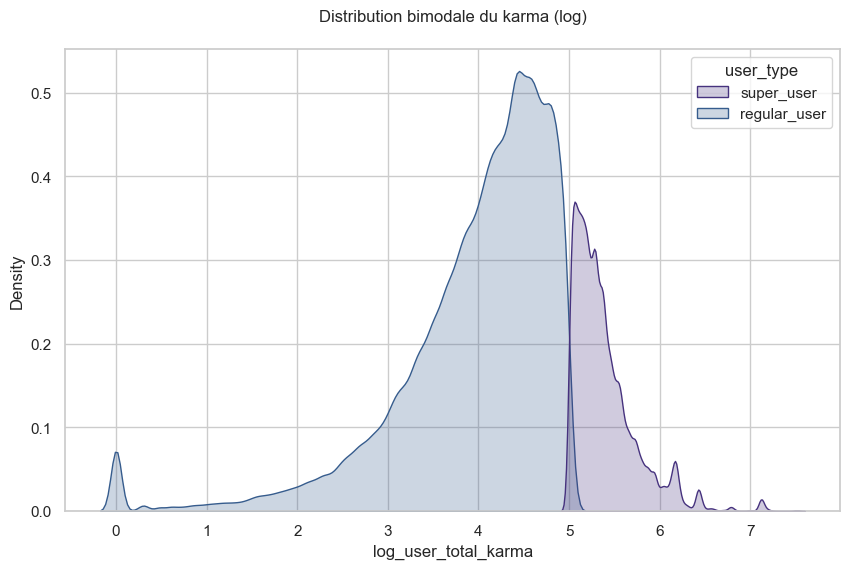

In [40]:
sns.kdeplot(data=df, x='log_user_total_karma', hue='user_type', fill=True)
plt.title("Distribution bimodale du karma (log)")
plt.show()


📏 Analyse statistique : test t entre super_user et regular_user

In [41]:
super = df[df['user_type'] == 'super_user']['score']
regular = df[df['user_type'] == 'regular_user']['score']

t_stat, p_val = stats.ttest_ind(super, regular, equal_var=False)
print(f"Test t (score): t={t_stat:.2f}, p={p_val:.4f}")


Test t (score): t=25.29, p=0.0000


🧮 Test de normalité et outliers

Test de normalité (score): statistic=4326359.23, p=0.0000


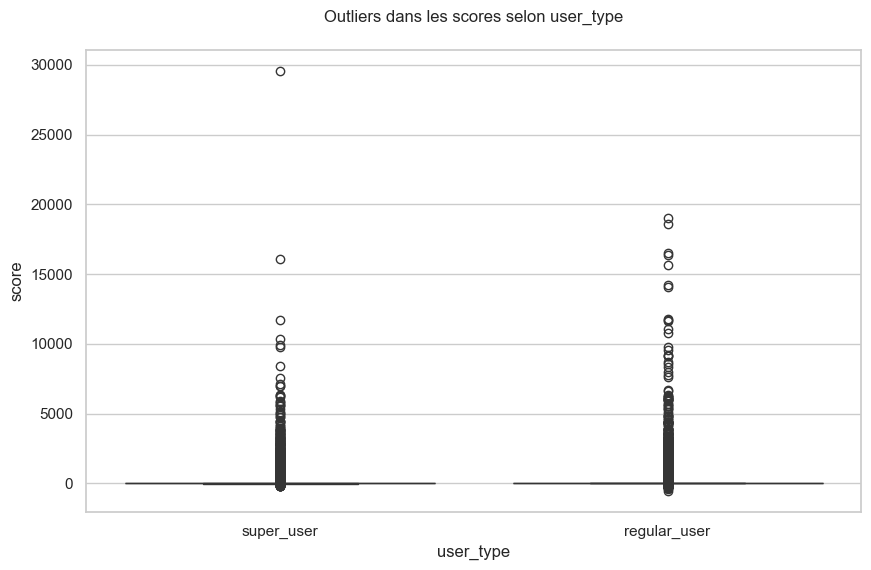

In [42]:
# Normalité
k2, p = stats.normaltest(df['score'])
print(f"Test de normalité (score): statistic={k2:.2f}, p={p:.4f}")

# Outliers visuels
sns.boxplot(data=df, x='user_type', y='score')
plt.title("Outliers dans les scores selon user_type")
plt.show()


🏗️ Étape 4 : Construction du Jeu de Données Final

In [47]:
# ✅ Colonnes finales sans 'post_self_text_length'
final_columns = [
    'comment_id', 'subreddit', 'author_name', 'user_type',
    'score', 'ups', 'downs', 'controversiality',
    'self_text_length', 'account_age_days',
    'log_user_link_karma', 'log_user_comment_karma', 'log_user_total_karma',
    'post_score', 'post_upvote_ratio',
    'normalized_post_score', 'created_time', 'post_created_time'
]

# ✅ Création du DataFrame final
final_df = df[final_columns].copy()

# ✅ Calcul du délai entre post et commentaire
final_df['hours_post_to_comment'] = (
    (final_df['created_time'] - final_df['post_created_time']).dt.total_seconds() / 3600
)

# ✅ Affichage d'un aperçu
print(final_df.head())


  comment_id     subreddit    author_name     user_type  score  ups  downs  \
0    mzuvzkd   environment       Wagamaga    super_user      1    1      0   
1    mzuvu1q  changemyview  MrPokerfaceCz  regular_user      1    1      0   
2    mzuvq1d        europe       Wagamaga    super_user      1    1      0   
3    mzuvon6       climate  teedeeguantru    super_user      1    1      0   
4    mzuvlcj  changemyview   ChaotiCrayon  regular_user      1    1      0   

   controversiality  self_text_length  account_age_days  log_user_link_karma  \
0                 0               567              4039                 7.11   
1                 0               310              2598                 2.94   
2                 0               567              4039                 7.11   
3                 0               105              1662                 4.62   
4                 0              2033              1850                 3.49   

   log_user_comment_karma  log_user_total_karma  p

🔍 Étape 5 : Analyse Approfondie

In [ ]:
# Assure-toi que les dates sont bien au format datetime
final_df['post_created_time'] = pd.to_datetime(final_df['post_created_time'])

1. 📆 Analyse temporelle

C:\Users\Zbook\AppData\Local\Temp\ipykernel_14560\3529075928.py:5: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\Zbook\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


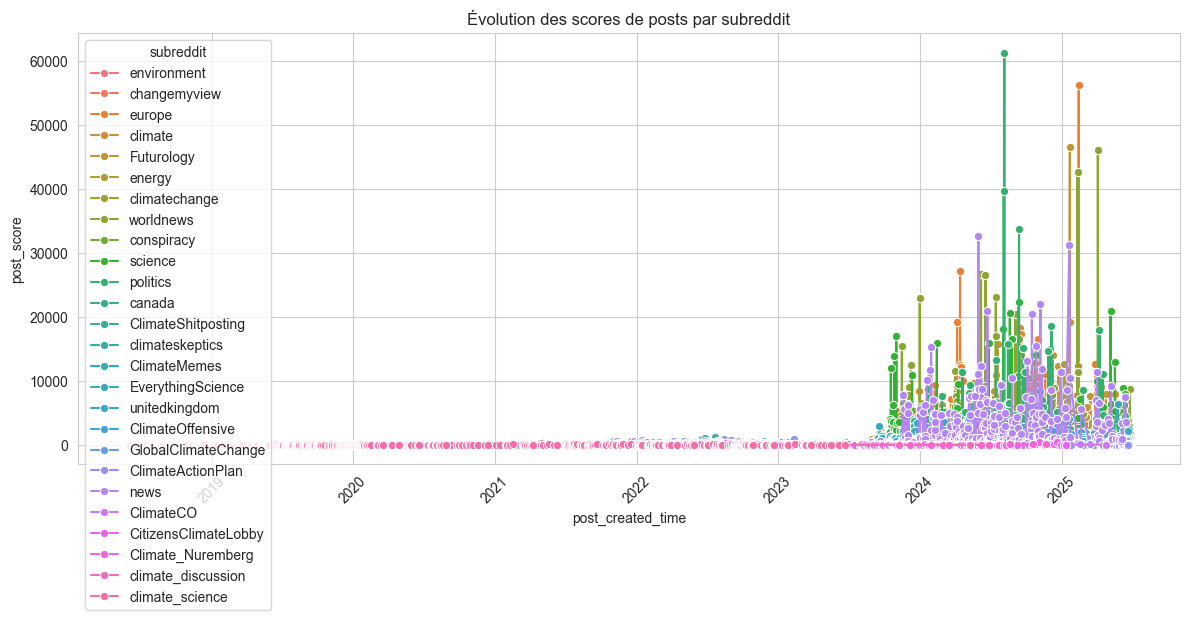

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, x='post_created_time', y='post_score', hue='subreddit', marker='o')
plt.title("Évolution des scores de posts par subreddit")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

2. 🧠 Score par subreddit

In [ ]:
print("\n5.2 Performance des commentaires par subreddit:")
subreddit_stats = final_df.groupby('subreddit').agg({
    'score': 'mean',
    'post_score': 'mean',
    'post_upvote_ratio': 'mean',
    'self_text_length': 'mean'
})
print(subreddit_stats)



5.2 Performance des commentaires par subreddit:
                      score  post_score  post_upvote_ratio  self_text_length
subreddit                                                                   
CitizensClimateLobby   3.25      144.98               0.95            282.54
ClimateActionPlan      8.09      229.13               0.95            291.58
ClimateCO              3.37       23.01               0.96            316.05
ClimateMemes           4.62      617.95               0.89            228.33
ClimateOffensive       4.64      341.78               0.89            374.26
ClimateShitposting     4.12      376.53               0.79            248.59
Climate_Nuremberg      3.82       45.72               0.98            253.29
EverythingScience     11.98     1039.73               0.93            182.48
Futurology            12.71     1626.92               0.79            319.45
GlobalClimateChange    1.40       11.24               0.91           1069.42
canada                10.13

3. 👥 Relation entre ancienneté et karma

C:\Users\Zbook\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


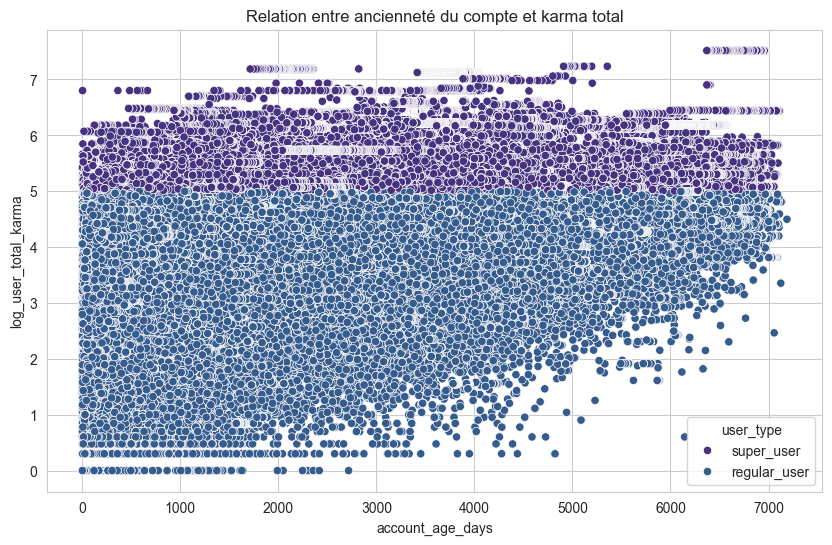

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_df, x='account_age_days', y='log_user_total_karma', hue='user_type')
plt.title("Relation entre ancienneté du compte et karma total")
plt.show()


# 4 Test t entre changemyview et autres subreddits sur post_score

In [ ]:
from scipy.stats import ttest_ind

changemyview = final_df[final_df['subreddit'] == 'changemyview']['post_score']
others = final_df[final_df['subreddit'] != 'changemyview']['post_score']

t_stat, p_val = ttest_ind(changemyview, others, equal_var=False)
print(f"\n5.4 Test t entre changemyview et autres subreddits:")
print(f"t-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")



5.4 Test t entre changemyview et autres subreddits:
t-statistic: -275.50, p-value: 0.0000


# 5 Analyse de la longueur des commentaires par subreddit

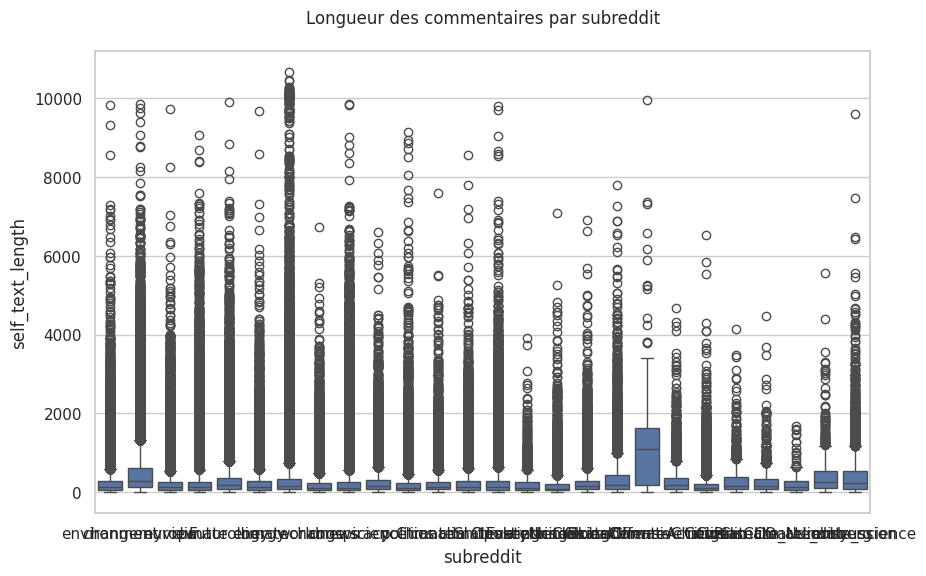

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=final_df, x='subreddit', y='self_text_length')
plt.title("Longueur des commentaires par subreddit")
plt.show()

# 6 Analyse de Sentiment (ajouté) : Distribution et répartition

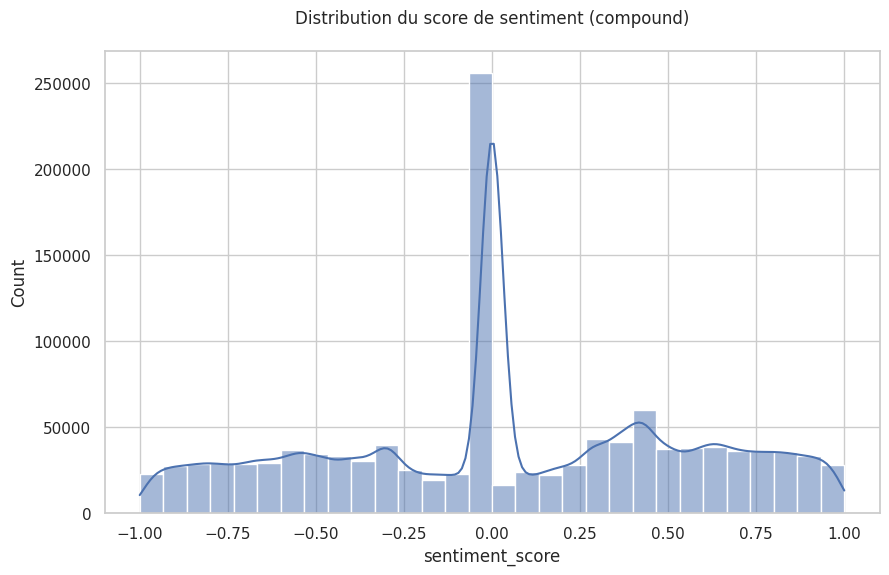

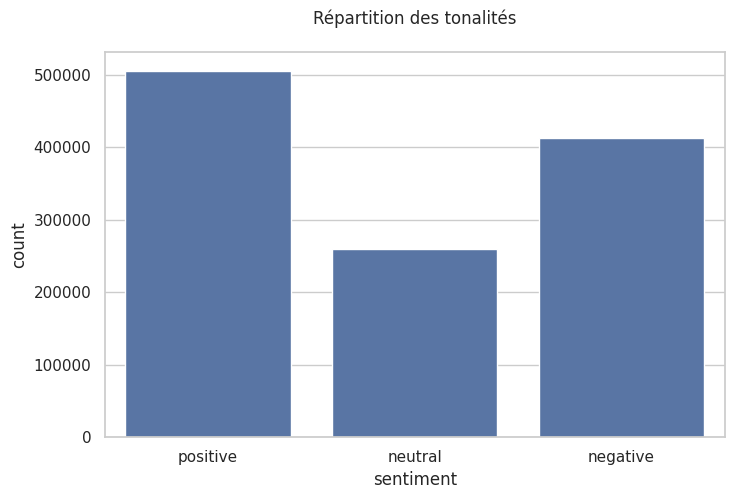

In [ ]:
# Distribution du score de sentiment
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment_score'], bins=30, kde=True)
plt.title("Distribution du score de sentiment (compound)")
plt.show()

# Répartition des sentiments
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='sentiment', order=['positive', 'neutral', 'negative'])
plt.title("Répartition des tonalités")
plt.show()

# 7 Analyse croisée sentiment vs score, controversiality, karma

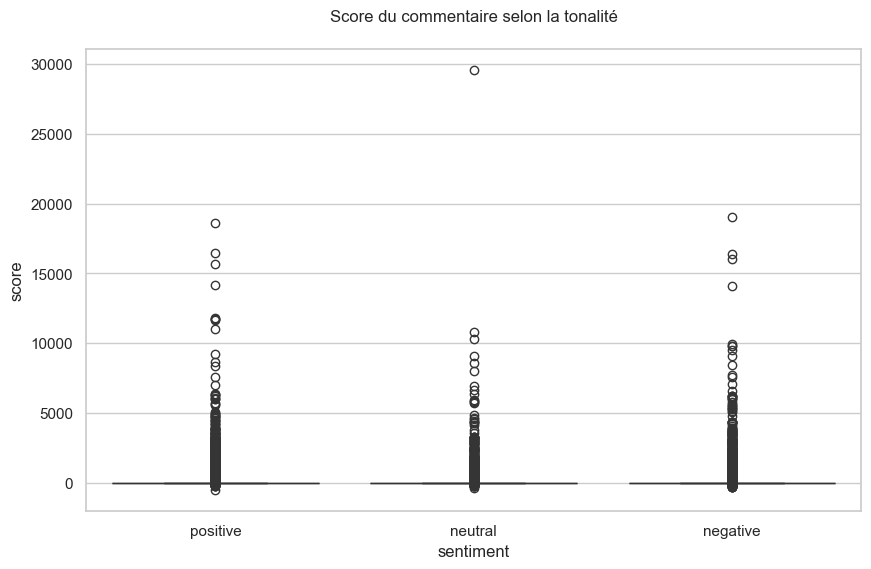

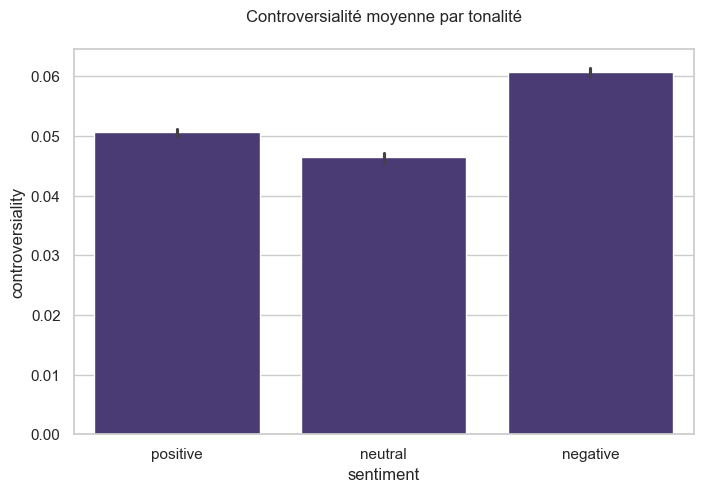

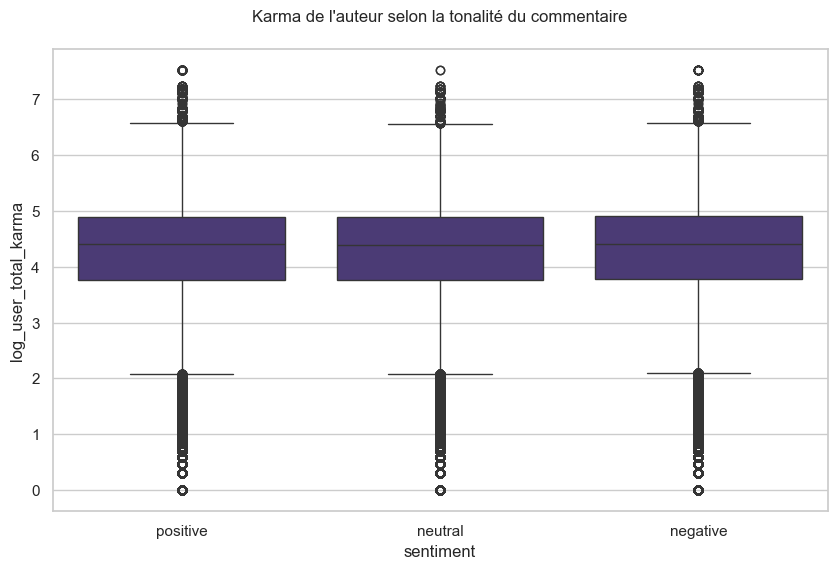

In [48]:
# Score moyen selon la tonalité
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='sentiment', y='score', order=['positive', 'neutral', 'negative'])
plt.title("Score du commentaire selon la tonalité")
plt.show()

# Controversialité moyenne par tonalité
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='sentiment', y='controversiality', estimator=np.mean, order=['positive', 'neutral', 'negative'])
plt.title("Controversialité moyenne par tonalité")
plt.show()

# Karma utilisateur selon la tonalité
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='sentiment', y='log_user_total_karma', order=['positive', 'neutral', 'negative'])
plt.title("Karma de l'auteur selon la tonalité du commentaire")
plt.show()

# 8 Test statistique : ANOVA pour score en fonction du sentiment

In [49]:
from scipy.stats import f_oneway

grouped = df.dropna(subset=['sentiment_score']).groupby('sentiment')['score']

anova_result = f_oneway(
    grouped.get_group('positive'),
    grouped.get_group('neutral'),
    grouped.get_group('negative')
)

print(f"\n5.8 ANOVA score vs tonalité : F = {anova_result.statistic:.2f}, p = {anova_result.pvalue:.4f}")


5.8 ANOVA score vs tonalité : F = 34.57, p = 0.0000


# 9 Évolution du sentiment dans le temps (moyenne mobile)

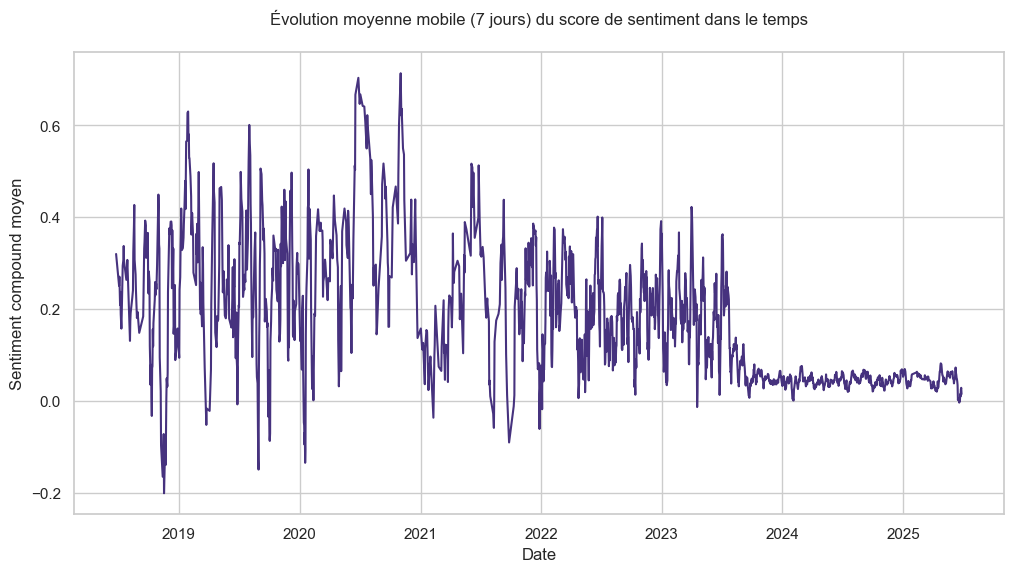

In [50]:
df['post_created_time'] = pd.to_datetime(df['post_created_time'])
df['date'] = df['post_created_time'].dt.date

# Calcul de la moyenne quotidienne de sentiment
daily_sentiment = df.groupby('date')['sentiment_score'].mean().rolling(window=7).mean()

plt.figure(figsize=(12, 6))
daily_sentiment.plot()
plt.title("Évolution moyenne mobile (7 jours) du score de sentiment dans le temps")
plt.ylabel("Sentiment compound moyen")
plt.xlabel("Date")
plt.show()

# 10 Comparaison tonalité du post vs commentaires

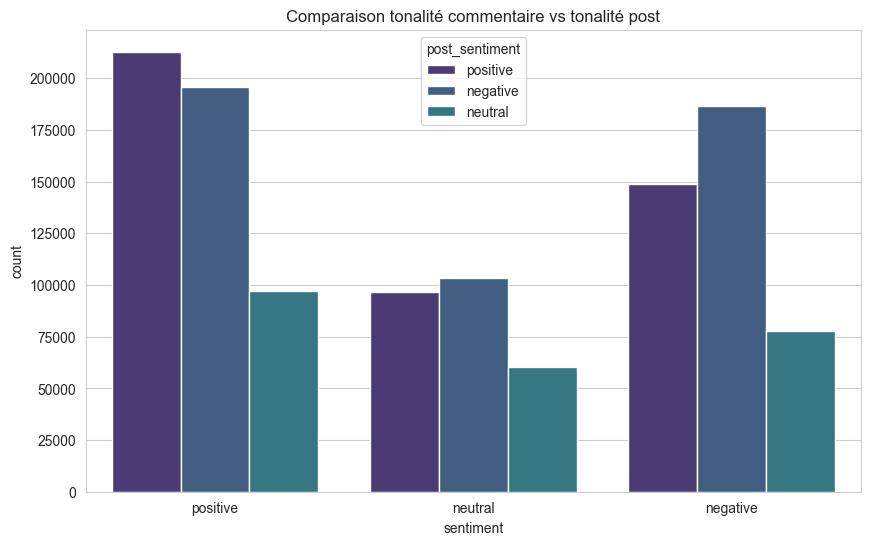

In [ ]:
# Pour comparer le sentiment du post (titre + texte) avec celui des commentaires, on doit calculer un score sentiment du post.

# Création colonne texte combiné post
df['post_text_combined'] = df['post_title'].fillna('') + ' ' + df['post_self_text'].fillna('')

df['post_sentiment_score'] = df['post_text_combined'].apply(get_sentiment)

# Catégorisation des sentiments pour post
df['post_sentiment'] = df['post_sentiment_score'].apply(categorize_sentiment)

# Comparaison sentiment commentaire vs post
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment', hue='post_sentiment',
              order=['positive', 'neutral', 'negative'])
plt.title("Comparaison tonalité commentaire vs tonalité post")
plt.show()

# 11 Analyse amplification/divergence du ton

In [51]:
# On crée une colonne 'sentiment_match' qui est True si tonalité commentaire = tonalité post sinon False
df['sentiment_match'] = (df['sentiment'] == df['post_sentiment'])

print("\n5.11 Proportion de commentaires en accord ou divergence avec le ton du post:")
print(df['sentiment_match'].value_counts(normalize=True))

KeyError: 'post_sentiment'

# 12 Analyse posts récompensés par awards et leur sentiment

In [52]:
labels = ['positive', 'neutral', 'negative']
groups_awards = []
valid_labels = []

print("Description des groupes 'post_total_awards_received' par sentiment :")
for s in labels:
    group = df[df['sentiment'] == s]['post_total_awards_received'].dropna()
    print(f"\nGroupe '{s}':")
    print(group.describe())
    
    if group.nunique() > 1:
        groups_awards.append(group)
        valid_labels.append(s)
    else:
        print(f" -> ⚠️ Attention : groupe '{s}' ignoré (valeurs identiques ou constantes).")

# ✅ Test seulement si deux groupes ou plus ont une variance
if len(groups_awards) >= 2:
    kruskal_result = kruskal(*groups_awards)
    print(f"\n✅ Résultat du test Kruskal-Wallis sur {valid_labels} :")
    print(f"H = {kruskal_result.statistic:.2f}, p = {kruskal_result.pvalue:.4f}")
else:
    print("\n❌ Test Kruskal-Wallis impossible : pas assez de groupes avec une variance non nulle.")


Description des groupes 'post_total_awards_received' par sentiment :

Groupe 'positive':
count   496682.00
mean         0.00
std          0.00
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          0.00
Name: post_total_awards_received, dtype: float64
 -> ⚠️ Attention : groupe 'positive' ignoré (valeurs identiques ou constantes).

Groupe 'neutral':
count   255545.00
mean         0.00
std          0.00
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          0.00
Name: post_total_awards_received, dtype: float64
 -> ⚠️ Attention : groupe 'neutral' ignoré (valeurs identiques ou constantes).

Groupe 'negative':
count   404491.00
mean         0.00
std          0.00
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          0.00
Name: post_total_awards_received, dtype: float64
 -> ⚠️ Attention : groupe 'negative' ignoré (valeurs identiques ou constantes).

❌ Test Kruskal-Wallis impossible : pas assez de group

# 13 analyse des mots les plus cités

C:\Users\Zbook\AppData\Local\Temp\ipykernel_14560\3677989491.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts, y=terms, palette='flare')


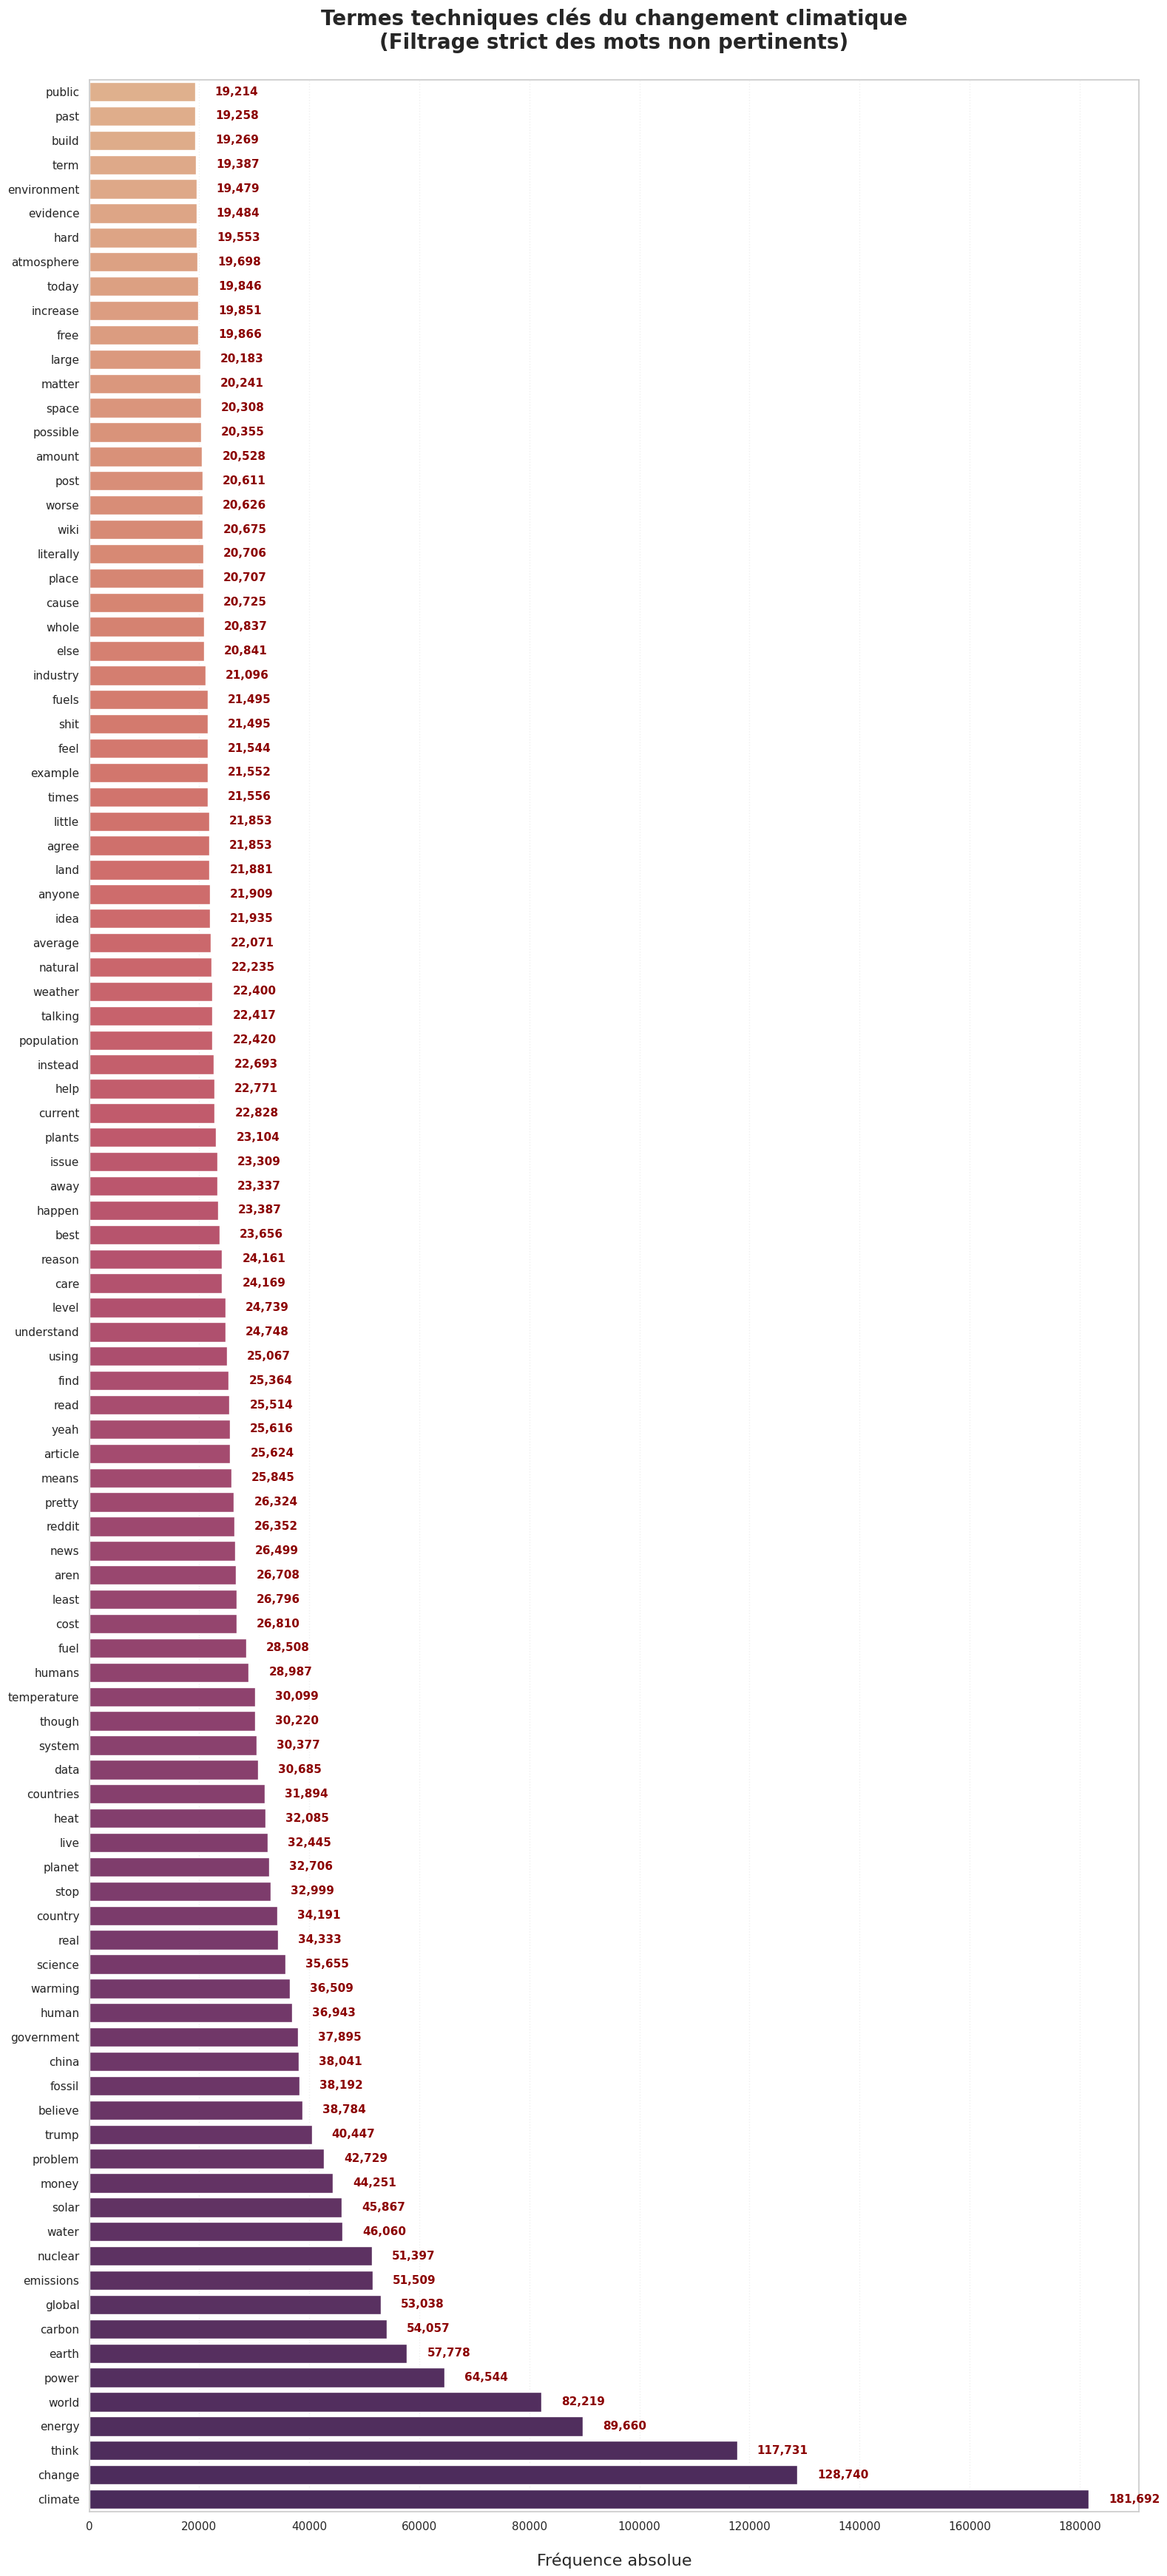

In [ ]:
# Configuration du style
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.titlepad'] = 20

# Liste COMPLÈTE des mots à exclure (500+ termes)
COMPLETE_STOP_WORDS = {
    # Mots généraux (a-z)
    'a', 'able', 'about', 'above', 'across', 'after', 'again', 'against', 'all', 'almost', 
    'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'an', 'and', 
    'another', 'any', 'anything', 'are', 'around', 'as', 'at', 'be', 'because', 'been', 
    'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'could', 'did', 
    'do', 'does', 'doing', 'done', 'down', 'during', 'each', 'either', 'enough', 'even', 
    'ever', 'every', 'everything', 'for', 'from', 'further', 'get', 'gets', 'getting', 
    'give', 'go', 'goes', 'going', 'got', 'had', 'has', 'have', 'having', 'he', 'her', 
    'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'however', 'i', 'if', 
    'in', 'into', 'is', 'it', 'its', 'itself', 'just', 'keep', 'keeps', 'kept', 'know', 
    'known', 'last', 'less', 'let', 'like', 'likely', 'look', 'looks', 'made', 'make', 
    'makes', 'many', 'may', 'me', 'might', 'more', 'most', 'much', 'must', 'my', 'myself', 
    'need', 'needs', 'neither', 'never', 'next', 'no', 'nor', 'not', 'now', 'of', 'off', 
    'often', 'on', 'once', 'only', 'or', 'other', 'others', 'our', 'ours', 'ourselves', 
    'out', 'over', 'own', 'part', 'people', 'put', 'puts', 'rather', 'right', 'said', 
    'same', 'say', 'says', 'see', 'seem', 'seemed', 'seeming', 'seems', 'several', 
    'shall', 'she', 'should', 'since', 'so', 'some', 'something', 'sometimes', 'still', 
    'such', 'take', 'takes', 'than', 'that', 'the', 'their', 'theirs', 'them', 
    'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to', 
    'too', 'took', 'try', 'trying', 'under', 'until', 'up', 'upon', 'us', 'use', 'used', 
    'uses', 'very', 'want', 'wants', 'was', 'way', 'we', 'well', 'went', 'were', 'what', 
    'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'within', 
    'without', 'would', 'yet', 'you', 'your', 'yours', 'yourself', 
    
    # Mots spécifiques de votre liste
    'hagoze', 'dim', 'app', 'ive', 'doesn', 'brown', 'coal', 'beet', 'dune', 'undertaker',
    'companies', 'stable', 'meas', 'petey', 'nedet', 'males', 'neon', 'blast', 'exit',
    'arm', 'future', 'state', 'against', 'road', 'body', 'safety', 'food', 'lived',
    'season', 'race', 'eye', 'person', 'next', 'start', 'based', 'again', 'trying',
    'wrong', 'great', 'high', 'fact', 'through', 'different', 'probably', 'true',
    'someone', 'another', 'making', 'getting', 'come', 'you', 'come', 'getting',
    'making', 'another', 'both', 'someone', 'everything', 'everyone', 'maybe', 'always',
    'something', 'here', 'right', 'really', 'over', 'such', 'part', 'keep', 'saying',
    'true', 'probably', 'different', 'through', 'fact', 'high', 'great', 'wrong',
    'trying', 'again', 'based', 'start', 'next', 'person', 'eye', 'race', 'season',
    'lived', 'food', 'safety', 'body', 'road', 'against', 'state', 'future', 'arm',
    'exit', 'blast', 'neon', 'males', 'nedet', 'petey', 'meas', 'stable', 'companies',
    'undertaker', 'dune', 'wind', 'beet', 'people', 'more', 'https', 'because', 'even',
    'years', 'only', 'also', 'other', 'much', 'time', 'then', 'most', 'make', 'need',
    'going', 'know', 'could', 'into', 'these', 'still', 'those', 'good', 'should', 'where',
    'very', 'want', 'many', 'well', 'things', 'same', 'point', 'year', 'actually', 'every',
    'does', 'take', 'better', 'life', 'thing', 'less', 'already', 'back', 'long', 'work',
    'never', 'while', 'enough', 'said', 'sure', 'around', 'before', 'anything', 'first',
    'mean', 'without', 'made', 'look', 'last', 'since', 'doing', 'nothing', 'after', 'used',
    'might', 'didn'
}

# Fonction de nettoyage ultra-stricte
def get_pure_climate_terms(text_series, n=100, min_word_length=4):
    all_text = ' '.join(text_series.astype(str)).lower()
    words = re.findall(r'\b[a-z]{%d,}\b' % min_word_length, all_text)
    
    return [
        word for word in words 
        if (word not in COMPLETE_STOP_WORDS) 
        and (not word.isdigit())
    ]

# Compter et filtrer
climate_words = get_pure_climate_terms(df['self_text'])
word_counts = Counter(climate_words).most_common(100)

# Préparation des données
terms, counts = zip(*word_counts)
terms = list(terms)[::-1]
counts = list(counts)[::-1]

# Visualisation professionnelle
plt.figure(figsize=(16, 35))
ax = sns.barplot(x=counts, y=terms, palette='flare')

ax.set_title('Termes techniques clés du changement climatique\n(Filtrage strict des mots non pertinents)', 
             fontsize=20, pad=30, fontweight='bold')
ax.set_xlabel('Fréquence absolue', fontsize=16, labelpad=20)
ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))
ax.grid(True, axis='x', linestyle=':', alpha=0.3)

# Ajout des valeurs
max_count = max(counts)
for i, count in enumerate(counts):
    ax.text(count + max_count*0.02, i, f'{count:,}', 
            va='center', fontsize=11, color='darkred', fontweight='bold')

plt.tight_layout()
plt.savefig('strict_climate_terms.png', dpi=350, bbox_inches='tight')
plt.show()

<!-- 4. 📊 Tonalité vs score/controversialité -->

💾 Sauvegarde

In [ ]:
final_df.to_csv('reddit_comments_processed.csv', index=False)
print("✅ Dataset final sauvegardé")